# Sentiment Analysis using Airline Tweets
Author: Matthew Huh

## Introduction

Social media is a treasure trove of textual data. It’s a free and easy way for users to express themselves and share whatever they want to say, get attention, and even start movements. 

It’s a powerful way for companies to get an idea of what users think about them, understand how their brands may be perceived, and identify ways to improve business by analyzing the concerns that users have with their products or services. And that is what I aim to accomplish in this project, by analyzing mentions of a few airlines and determining how people perceive their options, and evaluate what concerns people are mentioning. 


## About the Data

The data for this project has been obtained from two sources. The first data set is a collection of data pre-compiled from crowdflower, and is freely available on Kaggle. The second data set has been obtained using Twitter’s API (tweepy to be precise) 

The first data set has far more information as the data has been reviewed by people to determine the sentiment, and the rationale behind negative comments. The tweets have been evaluated by people and for the sake of simplicity, we will be assuming that those results are correct. The data set contains data from February 2015 and only mentions 6 different airlines ('American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America'). 

Our second data set is more recent, November 2018, and has both the same airlines in our training set, but also a few more airlines that aren’t. This is done in order to introduce data that we haven’t trained with yet. In theory, the models developed in this project should be able to do just that.

## Research Question

How accurate of a model can we build to determine a tweet's sentiment?

## Sources

https://www.kaggle.com/crowdflower/twitter-airline-sentiment (Pre-compiled Kaggle data)

http://nbviewer.jupyter.org/github/mhuh22/Thinkful/blob/master/Bootcamp/Unit%207/Twitter%20API%20%40Airline%20Tweets.ipynb (Tweepy Script)

<div class="alert alert-block alert-warning">
Note: The visuals for this project do not render correctly on Github; if you would like to view the presentation the way it was meant to be viewed, please click on the following link.

http://nbviewer.jupyter.org/github/mhuh22/Portfolio/blob/master/Sentiment%20Analysis%20with%20Airline%20Tweets/Airline%20Sentiment%20Analysis%20using%20Twitter%20Data.ipynb
</div>

## Packages

In [1]:
# Necessary imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline

# Modelling packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

# Natural Language processing
import nltk
import re
import spacy
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_rcv1
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

# Clustering packages
import sklearn.cluster as cluster
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, SpectralClustering, AffinityPropagation
from scipy.spatial.distance import cdist

# Plotly packages
import cufflinks as cf
import ipywidgets as widgets
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from scipy import special
py.offline.init_notebook_mode(connected=True)

C:\Users\mhuh22\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import the data
tweets = pd.read_csv("airline_tweets/Tweets.csv")

# Preview the dataset
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
# View the size of the dataset
tweets.shape

(14640, 15)

This dataset has a bit more information than we actually need for this project. We definitely need the text information since that is what we are evaluating, the sentiment since that is what we are trying to measure, and the reason to determine what clusters of complaints people are encountering. As for the rest, they could have some impact on the outcome, but they are not what we are trying to measure so, we'll drop the rest before continuing in order to improve our runtimes.

In [4]:
# Condense dataframe to only include what we want
tweets = tweets[['airline_sentiment', 'negativereason', 'airline', 'text']]

In [5]:
# Print unique airlines in the dataset
sorted(tweets['airline'].unique())

['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America']

In [6]:
# Describe unique occurences for each categorical variable
tweets.nunique()

airline_sentiment        3
negativereason          10
airline                  6
text                 14427
dtype: int64

## Data Visualization

In [7]:
# View distribution of tweets by sentiment 
# (Changing colors to red/gray/green would be nice)
trace = go.Pie(labels=tweets['airline_sentiment'].value_counts().index, 
              values=tweets['airline_sentiment'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Tweet Sentiment',
    height = 400,
    width = 500,
    autosize = False,
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

Based on the sentiment values in our dataset, it appears as though practically ⅔ of the tweets aren’t too happy about their choice of airline, while only ⅙ mention it in a positive way. We do have to keep in mind that these are tweets, not reviews, so they are mostly a form of expression, or expressing a concern/complaint more so than thinking about the experience as whole. 

In [8]:
# Plots the complaint reasons, and their frequency
# (It might be nice to somehow show how common each reason is for each airline)

# The input is the number of negative tweets by reason
data = [go.Bar(
    x = tweets.negativereason.value_counts().index,
    y = tweets.negativereason.value_counts(),
    opacity = 0.7
)]

# Create the layout
layout = go.Layout(
    title = 'Negative Tweets by Reason',
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = data, layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

Out of the 9000 negative tweets in our dataset, the reasons have been distilled into 10 categories, with the most common reason for it has being related to customer service. Let’s take a look at what those complaints look like.

In [9]:
tweets.loc[tweets['negativereason']=='Customer Service Issue'].head()

,airline_sentiment,negativereason,airline,text
24,negative,Customer Service Issue,Virgin America,@VirginAmerica you guys messed up my seating.....
25,negative,Customer Service Issue,Virgin America,@VirginAmerica status match program. I applie...
32,negative,Customer Service Issue,Virgin America,"@VirginAmerica help, left expensive headphones..."
33,negative,Customer Service Issue,Virgin America,"@VirginAmerica awaiting my return phone call, ..."
39,negative,Customer Service Issue,Virgin America,@VirginAmerica Your chat support is not workin...


In [10]:
# Show distribution of texts

trace1 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'negative'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Negative',
    marker = dict(color='rgba(200,0,0,.7)')
)

trace2 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'neutral'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Neutral',
    marker = dict(color='rgba(150,150,150,.7)')
)

trace3 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = tweets[tweets['airline_sentiment'] == 'positive'].groupby('airline')['airline_sentiment'].value_counts(),
    name = 'Positive',
    marker = dict(color='rgba(0,200,0,.7)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Airline Sentiment (Total Tweets)',
    barmode='group',
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

<div class="alert alert-block alert-warning">
For the above visual, please hover over the bars to see the actual values, and feel free to toggle the sentiment categories on the right.
</div>

First impressions say a lot, and the one you might be getting with this chart is that there are a lot of tweets about American, US Airways, and United, and it doesn’t look very good. Granted, they are some of the largest airlines in the world, but it seems like people have just as much to say.

### Class Imbalance

Based on the number of total tweets above, we can see that certain airlines don't have the same presence as others, namely Virgin America, which is a much smaller airline than the others in our dataset. In order to fix this issue, I will be upsampling the data so that all of the airlines will have an equal number of tweets and look at the ratio of tweet sentiments rather than the absolute numbers.

In [11]:
# Count # of tweets for each airline
tweets.groupby(['airline']).size().sort_values(ascending = False)

airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
dtype: int64

In [12]:
# Create temporary dataframe for all airlines to upsample and concatenate
tweets_united = tweets[tweets.airline=='United']
sample_size = len(tweets[tweets['airline']=='United'])

# Upsample all other airlines
tweets_usairways = resample(tweets[tweets.airline=='US Airways'], 
                            replace=True, n_samples=sample_size)
tweets_american = resample(tweets[tweets.airline=='American'], 
                           replace=True, n_samples=sample_size)
tweets_southwest = resample(tweets[tweets.airline=='Southwest'], 
                            replace=True, n_samples=sample_size)
tweets_delta = resample(tweets[tweets.airline=='Delta'], 
                        replace=True, n_samples=sample_size)
tweets_virgin = resample(tweets[tweets.airline=='Virgin America'], 
                         replace=True, n_samples=sample_size)

# Concatenate the individual dataframes
tweets = pd.concat([tweets_united, 
                   tweets_usairways, 
                   tweets_american, 
                   tweets_southwest,
                   tweets_delta,
                   tweets_virgin])

tweets = tweets.reset_index(drop=True)

# Count # of tweets for each airline to verify
tweets.groupby(['airline']).size()

airline
American          3822
Delta             3822
Southwest         3822
US Airways        3822
United            3822
Virgin America    3822
dtype: int64

In [13]:
# Show distribution of texts

trace1 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'negative'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Negative',
    marker = dict(color='rgba(200,0,0,.7)')
)

trace2 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'neutral'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Neutral',
    marker = dict(color='rgba(150,150,150,.7)')
)

trace3 = go.Bar(
    x = sorted(tweets['airline'].unique()),
    y = (tweets[tweets['airline_sentiment'] == 'positive'].groupby('airline')['airline_sentiment'].value_counts().values) / (tweets['airline'].value_counts().sort_index().values),
    name = 'Positive',
    marker = dict(color='rgba(0,200,0,.7)')
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    title = 'Airline Sentiment (Percentage)',
    barmode='group',
    yaxis = dict(title='% of tweets')
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

<div class="alert alert-block alert-warning">
For the above visual, please feel free to toggle the sentiment categories on the right.
</div>

After balancing the number of tweets for each airline, we can get a better idea of what people think about their choice of airline. Virgin America seems to fare the best with an almost equal number of positive and negative tweets, followed by Delta and Southwest. 

## Text Cleaning

There’s only so much that you can fit into 140 characters or less (the training set is from 2014, before Twitter updated their character limit), and it’s not as if most of these tweets have as much post-processing put into them as an academic essay, so there are going to be quite a few components that need to be cleaned up before modelling. To keep it short, this is the process for how what needs to happen first

* Remove special characters
* Remove excess spaces
* Remove stopwords like ‘like’, ‘the’ ‘and’ 
* Reduce words to their lemmas (base forms)

In [14]:
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    text = re.sub(r'\n',' ',text)
    text = re.sub(r'\t',' ',text)
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text

In [15]:
# Remove non-essential punctuation from the tweets
pd.options.display.max_colwidth = 200
tweets['text'] = tweets['text'].map(lambda x: text_cleaner(str(x)))
tweets['text'].head()

0                                                                                                                                @united thanks
1                                                                                   @united Thanks for taking care of that MR!! Happy customer.
2      @united still no refund or word via DM. Please resolve this issue as your Cancelled Flightled flight was useless to my assistant's trip.
3    @united Delayed due to lack of crew and now delayed again because there's a long line for deicing... Still need to improve service #united
4                                                                      @united thanks we filled it out. How's our luck with this? Is it common?
Name: text, dtype: object

In [16]:
# Reduce all text to their lemmas
lemmatizer = WordNetLemmatizer()

for tweet in tweets['text']:
    tweet = lemmatizer.lemmatize(tweet)

Now, the last part before modelling, converting the sentiment from text to numbers. Computers don’t really like working with characters, so we have to remap these values before continuing.

In [17]:
# Modify values of sentiment to numerical values
sentiment = {'negative': -1, 'neutral': 0, 'positive': 1}
tweets['airline_sentiment'] = tweets['airline_sentiment'].map(lambda x: sentiment[x])

# Natural Lanuage Processing

Now that we’ve reached the end of the course, it’s time to pull out all the stops for natural language processing. We’ll be trying out a few methods and combine them to generate the most useful factors for sentiment analysis prediction. We’ll try a few simpler methods like extracting the types of words used in each tweet using spacy, looking at the characteristics of each tweet, and finally extracting the most useful words in the dataset using tf-idf vectorization.

In [18]:
# Identify our predictor (tweets) and outcome (sentiment) variable
X = tweets['text']
y = tweets['airline_sentiment']

# Instantiating spaCy
nlp = spacy.load('en')
X_words = []

# Create list of dataframes that we'll combine later
nlp_methods = []

In [19]:
# Count parts of speech

for row in X:
    row_doc = nlp(row)          # Processing each row for tokens
    sent_len = len(row_doc)     # Calculating length of each sentence

    advs = 0                    # Initializing counts of different parts of speech
    verb = 0
    noun = 0
    adj = 0
    
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_words.append([row_doc, advs, verb, noun, adj, sent_len])

# Create dataframe with count of adverbs, verbs, nouns, and adjectives
X_count = pd.DataFrame(data=X_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Change token count to token percentage
for column in X_count.columns[1:5]:
    X_count[column] = X_count[column] / X_count['sent_length']

# Normalize X_count
X_counter = normalize(X_count.drop('BOW',axis=1))
X_counter  = pd.DataFrame(data=X_counter)

nlp_methods.append(X_counter)

In [20]:
# Track tweet composition

# Create new dataframe to track tweet characteristics
tweet_characteristics = pd.DataFrame()

# Track characteristics of each tweet
tweet_characteristics['word_count'] = tweets['text'].apply(lambda x: len(str(x).split(" ")))
tweet_characteristics['char_count'] = tweets['text'].str.len()
tweet_characteristics['stop_count'] = tweets['text'].apply(lambda x: len([x for x in x.split() if x in stopwords.words('english')]))
tweet_characteristics['special_count'] = tweets['text'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))

# Preview the tweet characteristics
tweet_characteristics.head()

nlp_methods.append(pd.DataFrame(normalize(tweet_characteristics)))

### Tf-idf Vectorization
The first types of features that we are going to add are the most useful words in our dataset. Now how are we going to determine which words are deemed the most "useful"? With TF-IDF vectorizer, of course.

TF tracks the term frequency, or how often each word appears in all articles of text, while idf (or Inverse Document Frequency) is a value that places less weight on variables that occur too often and lose their predictive power. Put together, it's a tool that allows us to assign an 'importance' value to each word in the entire dataset based on frequency in each row and throughout the database.

In [21]:
# Parameters for TF-idf vectorizer
vectorizer = TfidfVectorizer(max_df=0.5,            # Throw out words that occur in over half of tweets
                             min_df=3,              # Words need to apper at least 3 times to count
                             max_features=1200,       
                             stop_words='english',  # Ignore stop words
                             lowercase=True,        # Ignore case
                             use_idf=True,          # Penalize frequent words
                             norm=u'l2',
                             smooth_idf=True        # Add 1 to df in case we have to divide by 0
                            )

#Applying the vectorizer
X_tfidf=vectorizer.fit_transform(X)

#splitting into training and test sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

#Removes all zeros from the matrix
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Normalize the dataset    
X_norm = normalize(X_train_tfidf)

# Convert from tf-idf matrix to dataframe
X_normal  = pd.DataFrame(data=X_norm.toarray())

# Append tf-idf vectorizer to our list of nlp methods
nlp_methods.append(X_normal)

In [22]:
## Creating tf-idf matrix
synopsis_tfidf = vectorizer.fit_transform(tweets['text'])

# Getting the word list.
terms = vectorizer.get_feature_names()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    n_topics = range(components.shape[1])
    index= np.repeat(n_topics, n_top_words, axis=0)
    topwords=pd.Series(index=index)
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        # Combine loading and index into a string.
        chosenlist=chosen.index +" "+round(chosen,2).map(str) 
        topwords.loc[column]=chosenlist
    return(topwords)

# Number of words to look at for each topic.
n_top_words = 200

# Number of possible outcomes (3 = positive, neutral, negative)
ntopics = tweets['airline_sentiment'].nunique()

In [23]:
# Parameters for LSA
svd= TruncatedSVD(ntopics)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Time and run LSA model
start_time = timeit.default_timer()
synopsis_lsa = lsa.fit_transform(synopsis_tfidf)
elapsed_lsa = timeit.default_timer() - start_time

# Extract most common words for LSA
components_lsa = word_topic(synopsis_tfidf, synopsis_lsa, terms)
topwords=pd.DataFrame()
topwords['LSA']=top_words(components_lsa, n_top_words)

In [24]:
# Parameters for NNMF
nmf = NMF(alpha=0.0, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.0, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=200, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=0, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )

# Time and run NNMF model
start_time = timeit.default_timer()
synopsis_nmf = nmf.fit_transform(synopsis_tfidf)
elapsed_nmf = timeit.default_timer() - start_time

# Extract most common words for NNMF
components_nmf = word_topic(synopsis_tfidf, synopsis_nmf, terms)
topwords['NNMF']=top_words(components_nmf, n_top_words)

In [25]:
# View top words identified by LSA and NNMF
print('Top positive words: \n\n', topwords[:10], '\n\n')
print('Top neutral words: \n\n', topwords[200:210], '\n\n')
print('Top negative words: \n\n', topwords[400:410])

Top positive words: 

                     LSA                NNMF
0         flight 863.54        flight 42.82
0   southwestair 824.93  southwestair 30.41
0         united 761.71   americanair 29.94
0    americanair 739.49        united 28.63
0      usairways 687.61     usairways 26.72
0        jetblue 562.68     cancelled 19.22
0         thanks 484.34        thanks 15.63
0  virginamerica 452.83         thank 12.26
0           http 424.11      flightled 12.0
0           just 324.94          help 10.99 


Top neutral words: 

               LSA           NNMF
1  jetblue 755.76  jetblue 83.23
1     http 226.13     http 26.59
1    fleek 105.45    fleek 13.72
1     fleet 103.5    fleet 13.46
1        rt 43.34   thanks 12.68
1       jfk 30.73     thank 10.1
1      love 26.45    flight 9.42
1      wall 22.44      just 5.21
1      blue 21.41      great 5.0
1       ceo 20.18        rt 4.92 


Top negative words: 

                      LSA                 NNMF
2   virginamerica 749.26  virgina

In [26]:
# Create final training dataset
X_train = pd.concat(nlp_methods, axis=1)

# Review the data that we are placing into our models
X_train.head()

,0,1,2,3,4,0,1,2,3,0,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.000000,0.000000,0.235702,0.235702,0.942809,0.141421,0.989949,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.011831,0.017747,0.005916,0.999755,0.166899,0.984702,0.050070,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001479,0.005917,0.010354,0.004438,0.999918,0.166470,0.984345,0.057903,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.005486,0.009601,0.006858,0.001372,0.999914,0.170984,0.983159,0.064119,0.007124,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003086,0.009258,0.006172,0.009258,0.999890,0.190428,0.979343,0.068010,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


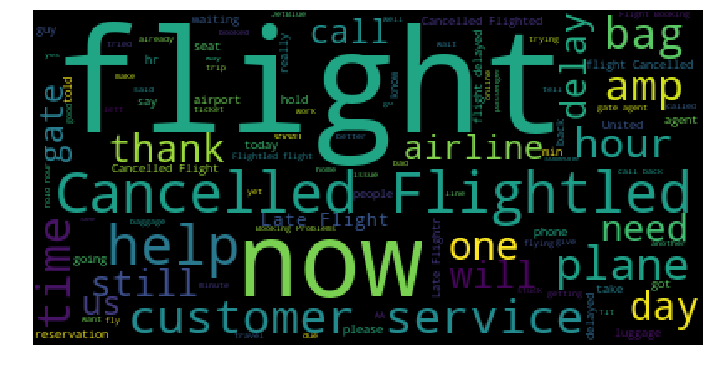

In [27]:
# Generates a wordcloud of the most common words in negative tweets
df=tweets[tweets['airline_sentiment']==-1]
words = ' '.join(df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      max_words = 100
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Modelling Phase

So, the tweets have been parsed and prepared for our models. We're trying to determine if it's possible to predict sentiment (a binary variable) so that means that we will require some classification models. As for which models to test, we will be using 
* Logistic Regression
* Random Forest Ensemble
* Gradient Boosting Ensemble
* Neural Networks

These four models differ fundamentally in how they operate, and range from least to most complex, meaning that logistic regression will almost always take the least amount of time, but the latter three will likely be more accurate.

In [28]:
# Create dataframe to track runtime and scores
models = ['Logistic regression' , 'Random forest', 'Gradient Boosting', 'Neural Networks']
runtime = []
train_score = []
test_score = []

In [29]:
def run_model(model):
    
    # Train the model
    train_set = cross_val_score(model, X_train_tfidf, y_train_tfidf, cv=5, n_jobs=-1)
    
    # Test and time the model
    start_time = timeit.default_timer()
    test_set = cross_val_score(model, X_test_tfidf, y_test_tfidf, cv=5, n_jobs=-1)
    elapsed_time = timeit.default_timer() - start_time
    
    # Append the scores and runtime to our dataframe
    train_score.append(train_set.mean())
    test_score.append(test_set.mean())
    runtime.append(elapsed_time)
    
    # Fit the model to the data
    model.fit(X_train_tfidf, y_train_tfidf)
    
    # Store the predicted values in a dataframe
    y_pred = model.predict(X_test_tfidf)
    
    # Print scores and runtime
    print(str(model), '\n\nTrain score: {:.5f}(+/- {:.2f})\n'.format(train_set.mean(), train_set.std()*2))
    print('Test score: {:.5f}(+/- {:.2f})\n'.format(test_set.mean(), test_set.std()*2))
    print('Runtime:', elapsed_time, 'seconds\n')
    
    # Generate and print the confusion matrix
    print('Confusion matrix:\n\n', confusion_matrix(y_test_tfidf, y_pred))
    
    # Print the model's statisitcs
    print('\nClassification Report:\n\n' + classification_report(y_test_tfidf, y_pred))

In [30]:
# Logistic regression model
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
run_model(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False) 

Train score: 0.81918(+/- 0.01)

Test score: 0.77256(+/- 0.02)

Runtime: 9.902313456999991 seconds

Confusion matrix:

 [[2997  223   56]
 [ 449  808   99]
 [ 155  104  842]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.83      0.91      0.87      3276
          0       0.71      0.60      0.65      1356
          1       0.84      0.76      0.80      1101

avg / total       0.81      0.81      0.81      5733



In [31]:
# Setting up grid search to return the best results for the random forest model
rfc = ensemble.RandomForestClassifier(n_jobs=-1)
param_grid = {'n_estimators' : [10, 20, 40, 60],
              'class_weight': ['balanced', 'balanced_subsample'],
             'oob_score': [True, False]}

# Run grid search to find ideal parameters
rfc_grid = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)

# Fit the model to the data
rfc_grid.fit(X_train_tfidf, y_train_tfidf)

# Run the model with the best parameters
rfc_2 = ensemble.RandomForestClassifier(**rfc_grid.best_params_)
run_model(rfc_2)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=60, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False) 

Train score: 0.88278(+/- 0.02)

Test score: 0.79628(+/- 0.03)

Runtime: 19.516328983999983 seconds

Confusion matrix:

 [[3099  131   46]
 [ 260 1025   71]
 [ 109   48  944]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.89      0.95      0.92      3276
          0       0.85      0.76      0.80      1356
          1       0.89      0.86      0.87      1101

avg / total       0.88      0.88      0.88      5733



In [32]:
# Gradient Boosting Model
gbc = ensemble.GradientBoostingClassifier()
run_model(gbc)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False) 

Train score: 0.75435(+/- 0.01)

Test score: 0.72929(+/- 0.03)

Runtime: 27.98217151499989 seconds

Confusion matrix:

 [[3122   82   72]
 [ 735  526   95]
 [ 338   99  664]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.74      0.95      0.84      3276
          0       0.74      0.39      0.51      1356
          1       0.80      0.60      0.69      1101

avg / total       0.75      0.75      0.73      5733



In [33]:
# Neural Network Model
mlp = MLPClassifier(hidden_layer_sizes=(100,10))
run_model(mlp)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) 

Train score: 0.88162(+/- 0.01)

Test score: 0.77378(+/- 0.02)

Runtime: 59.17632372000003 seconds

Confusion matrix:

 [[3057  151   68]
 [ 183 1103   70]
 [  87   63  951]]

Classification Report:

             precision    recall  f1-score   support

         -1       0.92      0.93      0.93      3276
          0       0.84      0.81      0.83      1356
          1       0.87      0.86      0.87      1101

avg / total       0.89      0.89      0.89      5733



In [34]:
# Create dataframes for the models and the scores
results = pd.DataFrame({'Model': models,
                        'Train_score': train_score,
                        'Test_score': test_score,
                        'Runtime': runtime})

# Print out the results
print('Scores: \n', results, '\n')

Scores: 
                  Model  Train_score  Test_score    Runtime
0  Logistic regression     0.819176    0.772555   9.902313
1        Random forest     0.882784    0.796281  19.516329
2    Gradient Boosting     0.754346    0.729295  27.982172
3      Neural Networks     0.881621    0.773777  59.176324 



In [35]:
# (Heavily consider separating the two later)

trace1 = go.Bar(
    x = results.Model,
    y = results.Test_score,
    name = 'Test Score'
)

trace2 = go.Bar(
    x = results.Model,
    y = results.Runtime,
    name = 'Runtime'
)

data = [trace1, trace2]
layout = go.Layout(
    title = 'Results',
    barmode = 'group'
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig, filename='stacked-bar')

## Model Comparison

So, after running all 4 types of models it seems as though logistic regression took the least time, but random forests fared almost as well due to parallelization and forgiving parameters, and is also the most accurate of the 4. While it was prone to overfitting, it still behaves well enough for the training set

## Clustering

Now, it's time to determine if we can identify any trends with our data through unsupervised machine learning. The way that we'll be doing that is through clustering, to determine if there are groups of tweet with a similar tf-idf score

In [36]:
X_train.head()

,0,1,2,3,4,0,1,2,3,0,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.000000,0.000000,0.235702,0.235702,0.942809,0.141421,0.989949,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.011831,0.017747,0.005916,0.999755,0.166899,0.984702,0.050070,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001479,0.005917,0.010354,0.004438,0.999918,0.166470,0.984345,0.057903,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.005486,0.009601,0.006858,0.001372,0.999914,0.170984,0.983159,0.064119,0.007124,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.003086,0.009258,0.006172,0.009258,0.999890,0.190428,0.979343,0.068010,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


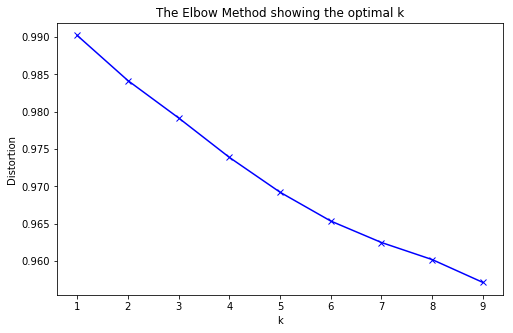

In [37]:
# Size of graph
X_train.dropna(inplace=True)
plt.rcParams['figure.figsize'] = [8,5]

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_train)
    kmeanModel.fit(X_train)
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_train_tfidf.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [38]:
# Calulate predicted values
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init=20)
y_pred = kmeans.fit_predict(X_train)

pd.crosstab(y_train_tfidf, y_pred)

col_0,0,1,2
airline_sentiment,,,
-1,7690,1030,1220
0,2132,971,924
1,1635,896,701


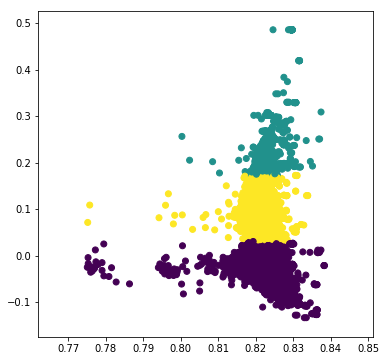

In [40]:
plt.figure(figsize=(6,6))

# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X_train)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred, cmap='viridis')
plt.show()

In [43]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y_train_tfidf))

Comparing k-means clusters against the data:
airline_sentiment    -1     0     1
row_0                              
0                  8680  2918  2414
1                   122   284   231
2                  1138   825   587


In [44]:
# View clustering score
print('Adjusted Rand Score: {:0.7}'.format(adjusted_rand_score(y_train_tfidf, y_pred)))
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_train, y_pred, sample_size=60000, metric='euclidean')))

Adjusted Rand Score: 0.07606666
Silhouette Score: 0.003654095


# Testing Set

Finally, we get to open the testing set. What if we decide to look at more recent tweets from the same airline, or how about we also decide to look at other airlines that weren't even in our dataset? 

Enough with the hypotheticals. The next dataset is a collection of recent tweets containing the testing data that we want and while we won't be able to assess its accuracy since we don't have the correct values, we should be able to get a good idea of measuring sentiment analysis for more recent tweets targetting the airlines in our dataset, as well as other airlines that actually aren't in our model. 

What this will demonstrate is how useful our models are for predicting sentiment analysis for tweets that our model has not seen yet.

In [45]:
# Import the training dataset
tweets_test = pd.read_csv("airline_tweets/test_set.csv", usecols=[1,2])

# Preview the data
tweets_test.head()

,airline,text
0,@AlaskaAir,"RT @AlaskaAir: Happy birthday to our Chief Football Officer, @DangeRussWilson! We hope your thirties are as fly as you! 🎂 https://t.co/XfTm…"
1,@AlaskaAir,@AlaskaAir My monthly+ flughts in and out of Montana will have to be with another airline if these flights after 9pm aren't possible.
2,@AlaskaAir,RT @ChrisEgan5: UW #Husky fans fired up for @pac12 championship game! Leaving #Seattle on @AlaskaAir on plane filled with @UW_Football @uw…
3,@AlaskaAir,@ChrisEgan5 @mcclainfan59 @pac12 @AlaskaAir @UW_Football @UW That's a Virgin Plane. 🤣
4,@AlaskaAir,"@AlaskaAir Stupid, stupid decision!!"


In [46]:
# View size of the testing dataframe
tweets_test.shape

(18000, 2)

In [47]:
# Print unique airlines in the test dataset
sorted(tweets_test['airline'].unique())

['@AlaskaAir',
 '@Allegiant',
 '@AmericanAir',
 '@Delta',
 '@FlyFrontier',
 '@HawaiianAir',
 '@JetBlue',
 '@SouthwestAir',
 '@SpiritAirlines',
 '@united']

Since the original dataset was obtained in February 2015, two of the airlines in the dataset no longer operate under the same name, 'US Airways' and 'Virgin' which have since merged with 'American' and 'Alaska' respectively. Due to this, we can only compare the remaining 4 airlines in the original dataset with 6 other major airlines currently in service in the United States.

In [48]:
# Remove non-essential punctuation from the tweets
pd.options.display.max_colwidth = 200
tweets_test['text'] = tweets_test['text'].map(lambda x: text_cleaner(str(x)))

# Reduce all text to their lemmas
for tweet in tweets_test['text']:
    tweet = lemmatizer.lemmatize(tweet)
    
# Specify the new test input
X = tweets_test['text']

# Apply the vectorizer to the test data
X_tfidf_2 = vectorizer.fit_transform(X)

# Predict the results using our best model
tweets_test['airline_sentiment'] = rfc_2.predict(X_tfidf_2)

In [49]:
# Modify values of sentiment to numerical values
sentiment = {-1:'negative', 0:'neutral', 1:'positive'}
tweets_test['airline_sentiment'] = tweets_test['airline_sentiment'].map(lambda x: sentiment[x])

In [50]:
# View distribution of tweets by sentiment 
# (Changing colors to red/gray/green would be nice)
trace = go.Pie(labels=tweets_test['airline_sentiment'].value_counts().index, 
              values=tweets_test['airline_sentiment'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Tweet Sentiment (Nov 2018)',
    height = 400,
    width = 500,
    autosize = False,
    yaxis = dict(title='Number of tweets')
)

fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename='cufflinks/simple')

When we apply the random forest model to our testing dataset, the results do look a bit more ... negative. Now, the differences in our dataset could be due to a number of things, so let's take a look at the data and see what our model spit out.

In [51]:
# Pivot table of airline sentiment
tweets_test.pivot_table(index=['airline_sentiment'],columns='airline', aggfunc='size', fill_value=0)

airline,@AlaskaAir,@Allegiant,@AmericanAir,@Delta,@FlyFrontier,@HawaiianAir,@JetBlue,@SouthwestAir,@SpiritAirlines,@united
airline_sentiment,,,,,,,,,,
negative,1728,1692,1693,1239,1566,1710,1566,1396,1489,1602
neutral,54,72,107,184,90,90,180,394,108,90
positive,18,36,0,377,144,0,54,10,203,108


<div class="alert alert-block alert-warning">
For the above visual, please feel free to toggle the sentiment categories on the right. For example, toggle negative and neutral off to view only positive tweets.
</div>

The model predicted so few positive results that these bars do look a bit off. Wasn't 'American' one of the most poorly received in the training set? You would be correct, but that doesn't appear to be the case here. 

* The training set was acquired in February 2015, and our test set in November 2018
* We didn't capture enough characteristics / words in our original model, and require a larger data set.

In [53]:
# Preview the top tweets for @AlaskaAir to see the correlation between tweets and predicted results
tweets_test.loc[tweets_test['airline']=='@AlaskaAir'].head()

,airline,text,airline_sentiment
0,@AlaskaAir,"RT @AlaskaAir: Happy birthday to our Chief Football Officer, @DangeRussWilson! We hope your thirties are as fly as you! 🎂 https://t.co/XfTm…",negative
1,@AlaskaAir,@AlaskaAir My monthly+ flughts in and out of Montana will have to be with another airline if these flights after 9pm aren't possible.,negative
2,@AlaskaAir,RT @ChrisEgan5: UW #Husky fans fired up for @pac12 championship game! Leaving #Seattle on @AlaskaAir on plane filled with @UW_Football @uw…,negative
3,@AlaskaAir,@ChrisEgan5 @mcclainfan59 @pac12 @AlaskaAir @UW_Football @UW That's a Virgin Plane. 🤣,negative
4,@AlaskaAir,"@AlaskaAir Stupid, stupid decision!!",negative


In [54]:
# Preview the top tweets for 'American' in our test set
tweets.loc[tweets['airline']=='American'].head()

,airline_sentiment,negativereason,airline,text
7644,-1,Customer Service Issue,American,"@AmericanAir I've been on hold for 55 mins about my Cancelled Flighted international flight. Am out of country, so can't leave a call back #. Help?"
7645,-1,Customer Service Issue,American,“@AmericanAir Thanks for info on super large passengers- the extra seat Mr. Big needed was the one i was sitting in already #customerservice
7646,-1,Customer Service Issue,American,"@AmericanAir Been trying to call all day, get hung up on every time. Your guys are horrible!"
7647,-1,Late Flight,American,@AmericanAir Hey so I'm very disappointed with my time traveling with you! I've had the worst experience and both times the flight delayed!
7648,0,NaN,American,@AmericanAir Any way that we could look at other options for today?


## Conclusion

For this project, I aimed to build the best model that I could for performing sentiment analysis based on a fairly small training set, and apply the model to a more recent, equally sized testing set. Based on the training, and validation steps of the process, the model was able to do fairly well within the dataset, but when tasked to apply the same model on external data, the model wasn't able to hold up quite as well.

## Next Steps

Granted, the project may not achieved an ideal outcome, it has a sufficient framework for performing the task, and would likely stand to benefit from inputting more data, in the training phase, and incorporating a larger vocabulary, or testing it with an expansive word2vec model.